In [1]:
from torchvision import datasets, transforms

In [9]:
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.distributions import kl_divergence
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=128, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', train=False, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                       ])),
    batch_size=1, shuffle=True)


# Network

In [5]:
def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape).to(device)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = 1.
        self.K = 10
        self.N = 30
        self.create_encoder()
        self.create_decoder()
        
    def create_encoder(self):
        """
            Input for the encoder is a BS x 784 tensor
            Output from the encoder are the log probabilities of the categorical distribution
        """
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.K*self.N)
        )
        
    def create_decoder(self):
        """
            Input for the decoder is a BS x N*K tensor
            Output from the decoder are the log probabilities of the bernoulli pixels
        """
        self.decoder = nn.Sequential(
            nn.Linear(self.N*self.K, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.LogSigmoid()
        )
        
    def sample(self, img):
        with torch.no_grad():
            logits_nz = self.encoder(img)
            logits_z = F.log_softmax(logits_nz.view(-1, self.N, self.K), dim=-1)
            latent_vars = sample_gumbel_softmax(logits_z, self.temperature)
            logits_x = self.decoder(latent_vars)
            dist_x = torch.distributions.Bernoulli(logits=logits_x)
            sampled_img = dist_x.sample((1,))
            
        return sampled_img.cpu().numpy()
        
    def forward(self, img, anneal=1.):
        """
            Input: 
            img: Tensor of shape BS x 784
        """
        # Encoding
        logits_nz = self.encoder(img)
        logits_z = F.log_softmax(logits_nz.view(-1, self.N, self.K), dim=-1)
        posterior_dist = torch.distributions.Categorical(logits=logits_z)
        prior_dist = torch.distributions.Categorical(probs=torch.ones_like(logits_z)/self.K)
        
        # Sampling
        latent_vars = sample_gumbel_softmax(logits_z, self.temperature).view(-1, self.N*self.K)
        
        # Decoding
        logits_x = self.decoder(latent_vars)
        dist_x = torch.distributions.Bernoulli(logits=logits_x)

        # Losses
        ll = dist_x.log_prob(img).sum(dim=-1)
#         kl1 = posterior_dist.probs * (logits_z - torch.log(torch.ones_like(logits_z)/self.K))
        kl = kl_divergence(posterior_dist, prior_dist).sum(-1)
        assert torch.all(kl > 0)
        assert torch.all(ll < 0)
        elbo = ll - kl
        loss = -elbo.mean()
        return loss

In [10]:
def sample(model, img):
    with torch.no_grad():
        logits_nz = model.encoder(img)
        logits_z = F.log_softmax(logits_nz.view(-1, model.N, model.K), dim=-1)
        latent_vars = sample_gumbel_softmax(logits_z, model.temperature).view(-1, model.N*model.K)
        logits_x = model.decoder(latent_vars)
        dist_x = torch.distributions.Bernoulli(logits=logits_x)
        sampled_img = dist_x.sample((1,))

    return sampled_img.cpu().numpy()

In [14]:
def plot_img(model):
    for batch_idx, (data, target) in enumerate(test_loader):
        img_flat = sample(model, data.view(-1, 28*28).to(device))
        plt.figure()
        plt.subplot(121)
        plt.imshow(img_flat.reshape(28,28))
        plt.subplot(122)
        plt.imshow(data.reshape(28,28))
        plt.show()
        break

In [15]:
def train(model, optimizer, maxiters):
    iters = 0
    while iters < maxiters:
        for batch_idx, (data, target) in enumerate(train_loader):
            iters+=1
#             anneal = min(1., epoch*.1)
            optimizer.zero_grad()
            data = data.to(device)
            loss = model(data.view(-1, 28*28))
    #             neg_elbo = -elbo
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                model.temperature = np.maximum(model.temperature * np.exp(-ANNEAL_RATE * batch_idx), temp_min)
                print("New Model Temperature: {}".format(model.temperature))
            if iters % 100 == 0:
                plot_img(model)
                print('Train Iteration: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    iters, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

New Model Temperature: 1.0


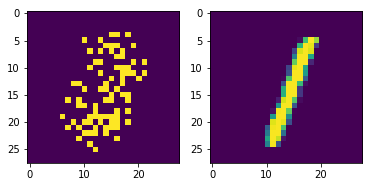

Train Iteration: 100 [12672/60000 (21%)]	Loss: 205.179291
New Model Temperature: 0.997004495503373


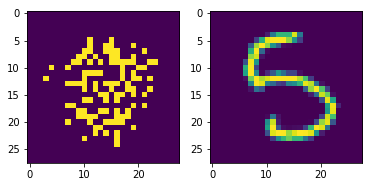

Train Iteration: 200 [25472/60000 (42%)]	Loss: 187.096405
New Model Temperature: 0.9910403787728836


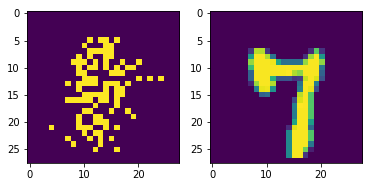

Train Iteration: 300 [38272/60000 (64%)]	Loss: 187.346329
New Model Temperature: 0.9821610323583007


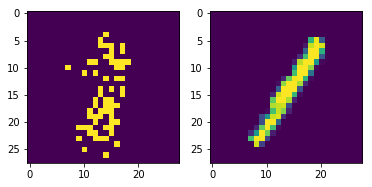

Train Iteration: 400 [51072/60000 (85%)]	Loss: 189.956055
New Model Temperature: 0.970445533548508
New Model Temperature: 0.970445533548508


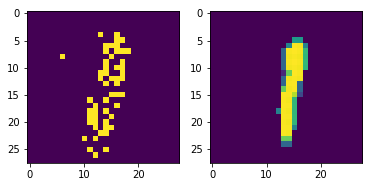

Train Iteration: 500 [3840/60000 (6%)]	Loss: 193.834396
New Model Temperature: 0.9675385595890319


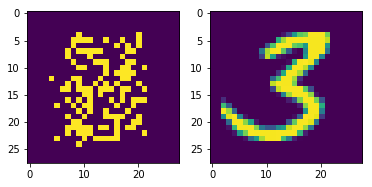

Train Iteration: 600 [16640/60000 (28%)]	Loss: 178.103271
New Model Temperature: 0.9617507091463666


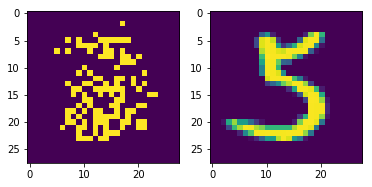

Train Iteration: 700 [29440/60000 (49%)]	Loss: 172.169342
New Model Temperature: 0.9531337870775046


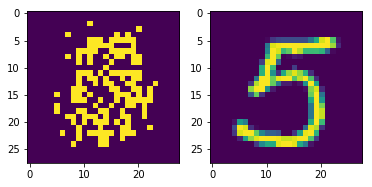

Train Iteration: 800 [42240/60000 (70%)]	Loss: 172.517700
New Model Temperature: 0.9417645335842486


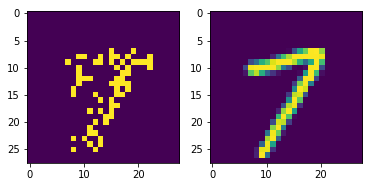

Train Iteration: 900 [55040/60000 (92%)]	Loss: 165.176849
New Model Temperature: 0.9417645335842486


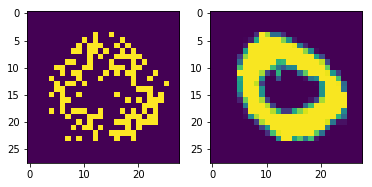

Train Iteration: 1000 [7808/60000 (13%)]	Loss: 164.834839
New Model Temperature: 0.9389434736891331


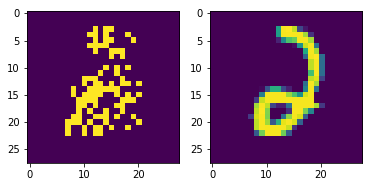

Train Iteration: 1100 [20608/60000 (34%)]	Loss: 159.287628
New Model Temperature: 0.9333266800782019


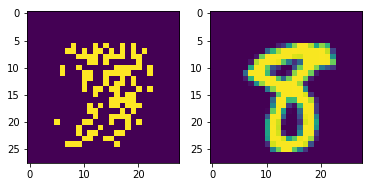

Train Iteration: 1200 [33408/60000 (56%)]	Loss: 158.914444
New Model Temperature: 0.9249644265435392


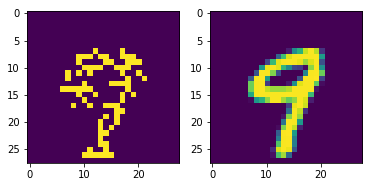

Train Iteration: 1300 [46208/60000 (77%)]	Loss: 156.598373
New Model Temperature: 0.9139311852712281


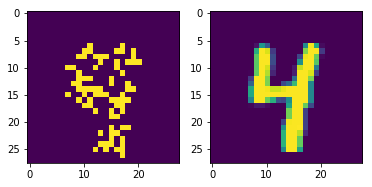

Train Iteration: 1400 [59008/60000 (98%)]	Loss: 157.220688
New Model Temperature: 0.9139311852712281


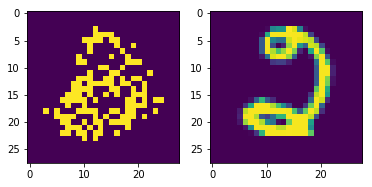

Train Iteration: 1500 [11776/60000 (20%)]	Loss: 157.921890
New Model Temperature: 0.9111935002961404


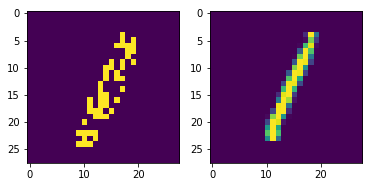

Train Iteration: 1600 [24576/60000 (41%)]	Loss: 155.480621
New Model Temperature: 0.9057427080235484


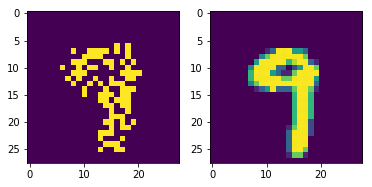

Train Iteration: 1700 [37376/60000 (62%)]	Loss: 155.028183
New Model Temperature: 0.8976275964304348


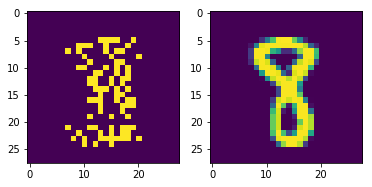

Train Iteration: 1800 [50176/60000 (84%)]	Loss: 152.712982
New Model Temperature: 0.8869204367171574
New Model Temperature: 0.8869204367171574


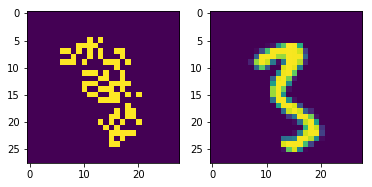

Train Iteration: 1900 [2944/60000 (5%)]	Loss: 155.766235
New Model Temperature: 0.8842636625608208


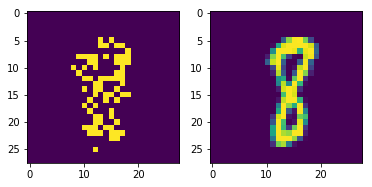

Train Iteration: 2000 [15744/60000 (26%)]	Loss: 148.800446
New Model Temperature: 0.8789739655455832


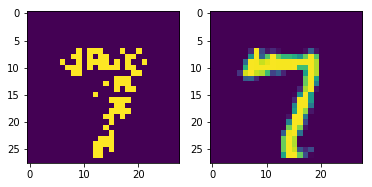

Train Iteration: 2100 [28544/60000 (48%)]	Loss: 145.919617
New Model Temperature: 0.8710986917457983


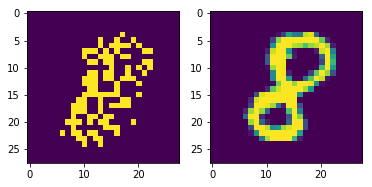

Train Iteration: 2200 [41344/60000 (69%)]	Loss: 151.076508
New Model Temperature: 0.8607079764250578


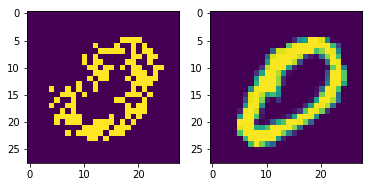

Train Iteration: 2300 [54144/60000 (90%)]	Loss: 149.218933
New Model Temperature: 0.8607079764250578


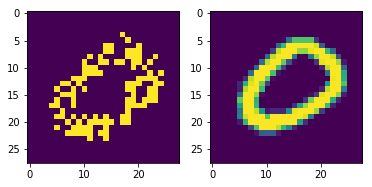

Train Iteration: 2400 [6912/60000 (12%)]	Loss: 145.433746
New Model Temperature: 0.8581297218113938


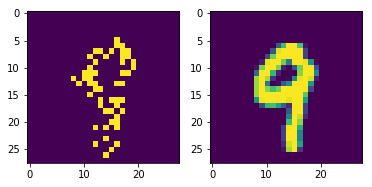

Train Iteration: 2500 [19712/60000 (33%)]	Loss: 151.533615
New Model Temperature: 0.8529963589691315


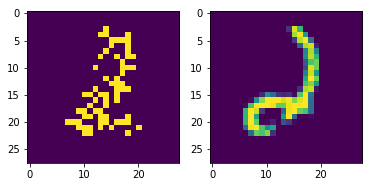

Train Iteration: 2600 [32512/60000 (54%)]	Loss: 152.944214
New Model Temperature: 0.8453538346846587


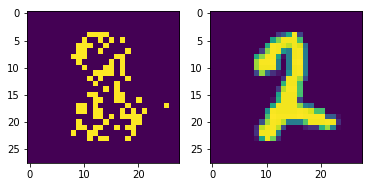

Train Iteration: 2700 [45312/60000 (75%)]	Loss: 148.645416
New Model Temperature: 0.835270211411272


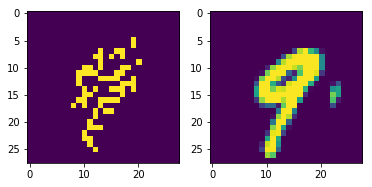

Train Iteration: 2800 [58112/60000 (97%)]	Loss: 147.439590
New Model Temperature: 0.835270211411272


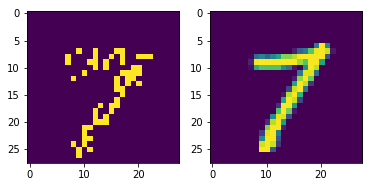

Train Iteration: 2900 [10880/60000 (18%)]	Loss: 149.624756
New Model Temperature: 0.832768155737091


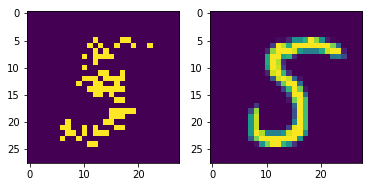

Train Iteration: 3000 [23680/60000 (39%)]	Loss: 153.763428
New Model Temperature: 0.8277865066947336


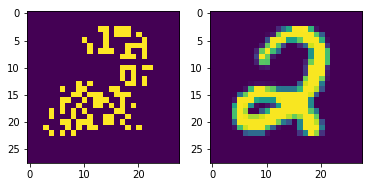

Train Iteration: 3100 [36480/60000 (61%)]	Loss: 151.079147
New Model Temperature: 0.8203698531378311


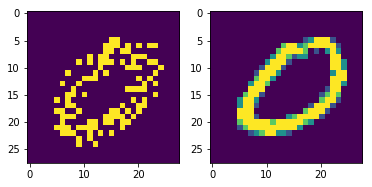

Train Iteration: 3200 [49280/60000 (82%)]	Loss: 143.718567
New Model Temperature: 0.8105842459701871
New Model Temperature: 0.8105842459701871


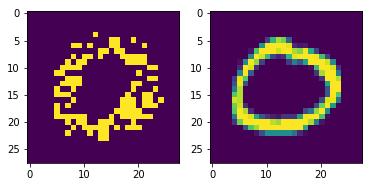

Train Iteration: 3300 [2048/60000 (3%)]	Loss: 141.524811
New Model Temperature: 0.8081561372164884


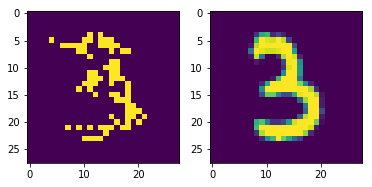

Train Iteration: 3400 [14848/60000 (25%)]	Loss: 150.185028
New Model Temperature: 0.8033217181536265


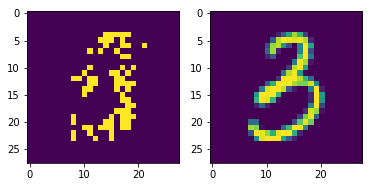

Train Iteration: 3500 [27648/60000 (46%)]	Loss: 148.096329
New Model Temperature: 0.7961242598354537


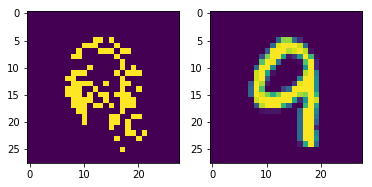

Train Iteration: 3600 [40448/60000 (67%)]	Loss: 146.985870
New Model Temperature: 0.7866278610665534


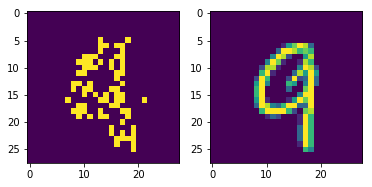

Train Iteration: 3700 [53248/60000 (89%)]	Loss: 143.400253
New Model Temperature: 0.7866278610665534


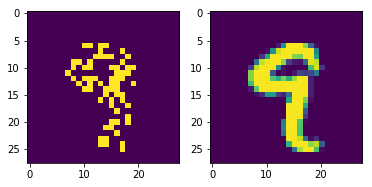

Train Iteration: 3800 [6016/60000 (10%)]	Loss: 137.799576
New Model Temperature: 0.7842715137715565


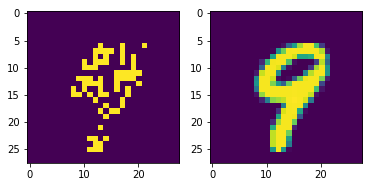

Train Iteration: 3900 [18816/60000 (31%)]	Loss: 147.202454
New Model Temperature: 0.7795799733847004


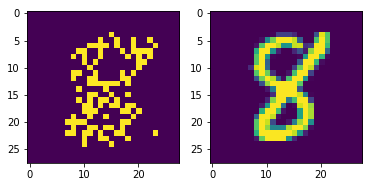

Train Iteration: 4000 [31616/60000 (53%)]	Loss: 145.507874
New Model Temperature: 0.772595232106928


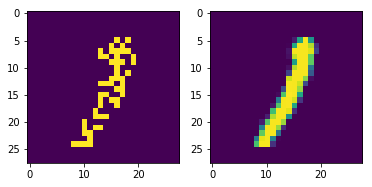

Train Iteration: 4100 [44416/60000 (74%)]	Loss: 152.225143
New Model Temperature: 0.7633794943368531


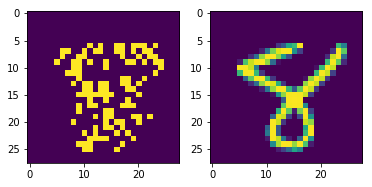

Train Iteration: 4200 [57216/60000 (95%)]	Loss: 144.191559
New Model Temperature: 0.7633794943368531


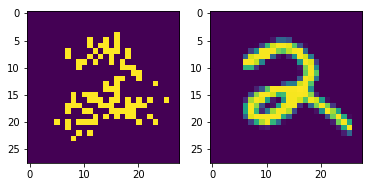

Train Iteration: 4300 [9984/60000 (17%)]	Loss: 144.429718
New Model Temperature: 0.7610927876289343


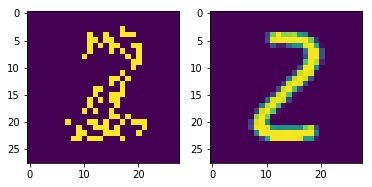

Train Iteration: 4400 [22784/60000 (38%)]	Loss: 139.791718
New Model Temperature: 0.7565399032150474


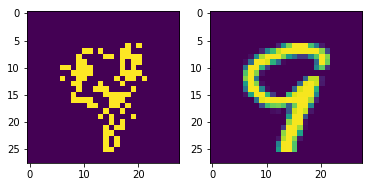

Train Iteration: 4500 [35584/60000 (59%)]	Loss: 144.005341
New Model Temperature: 0.7497615922390413


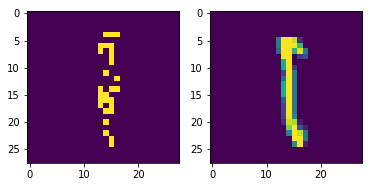

Train Iteration: 4600 [48384/60000 (81%)]	Loss: 144.864227
New Model Temperature: 0.7408182206817178
New Model Temperature: 0.7408182206817178


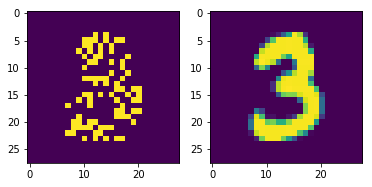

Train Iteration: 4700 [1152/60000 (2%)]	Loss: 143.582977
New Model Temperature: 0.7385990963704825


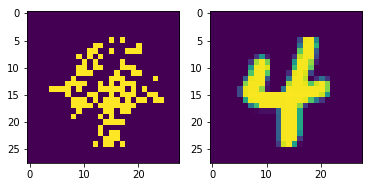

Train Iteration: 4800 [13952/60000 (23%)]	Loss: 142.958679
New Model Temperature: 0.7341807700262634


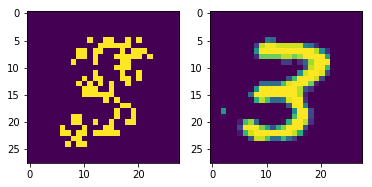

Train Iteration: 4900 [26752/60000 (45%)]	Loss: 142.349976
New Model Temperature: 0.7276027884145955


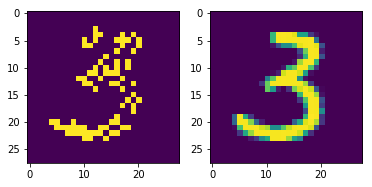

Train Iteration: 5000 [39552/60000 (66%)]	Loss: 137.947296
New Model Temperature: 0.7189237334319262


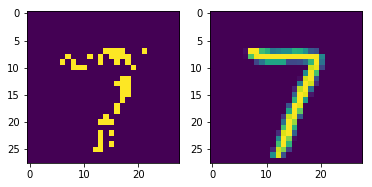

Train Iteration: 5100 [52352/60000 (87%)]	Loss: 148.914597
New Model Temperature: 0.7189237334319262


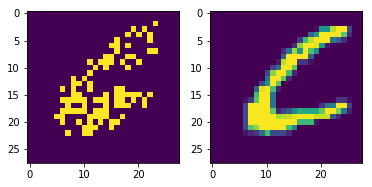

Train Iteration: 5200 [5120/60000 (9%)]	Loss: 141.459991
New Model Temperature: 0.716770194155699


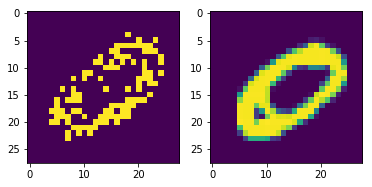

Train Iteration: 5300 [17920/60000 (30%)]	Loss: 145.471039
New Model Temperature: 0.7124824490891918


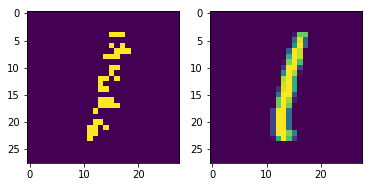

Train Iteration: 5400 [30720/60000 (51%)]	Loss: 144.424728
New Model Temperature: 0.7060988762143844


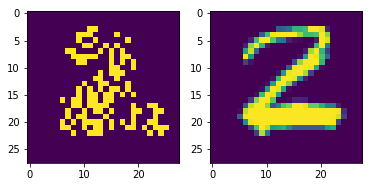

Train Iteration: 5500 [43520/60000 (72%)]	Loss: 144.384521
New Model Temperature: 0.697676326071031


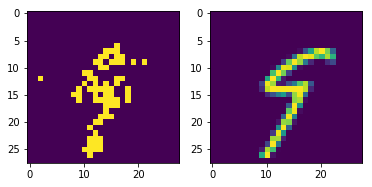

Train Iteration: 5600 [56320/60000 (94%)]	Loss: 140.859543
New Model Temperature: 0.697676326071031


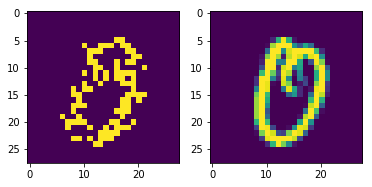

Train Iteration: 5700 [9088/60000 (15%)]	Loss: 138.985260
New Model Temperature: 0.6955864334990951


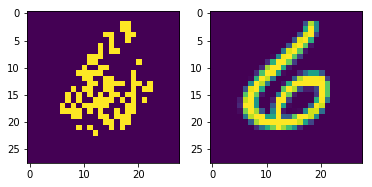

Train Iteration: 5800 [21888/60000 (36%)]	Loss: 141.904556
New Model Temperature: 0.6914254104503086


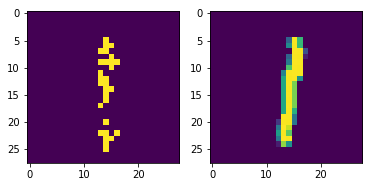

Train Iteration: 5900 [34688/60000 (58%)]	Loss: 141.898712
New Model Temperature: 0.6852305006658703


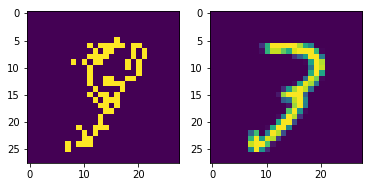

Train Iteration: 6000 [47488/60000 (79%)]	Loss: 145.109451
New Model Temperature: 0.6770568744981648
New Model Temperature: 0.6770568744981648


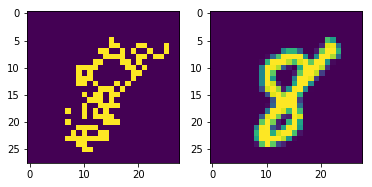

Train Iteration: 6100 [256/60000 (0%)]	Loss: 146.778992
New Model Temperature: 0.6750287475861333


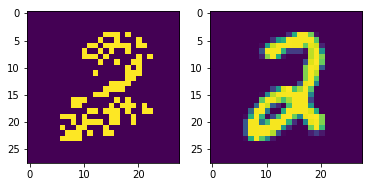

Train Iteration: 6200 [13056/60000 (22%)]	Loss: 132.485992
New Model Temperature: 0.670990701353446


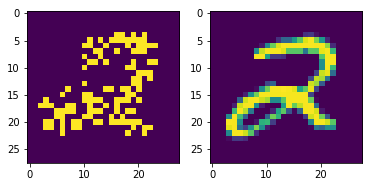

Train Iteration: 6300 [25856/60000 (43%)]	Loss: 141.221588
New Model Temperature: 0.6649788788224019


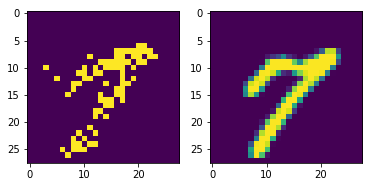

Train Iteration: 6400 [38656/60000 (64%)]	Loss: 145.177170
New Model Temperature: 0.6570468198150567


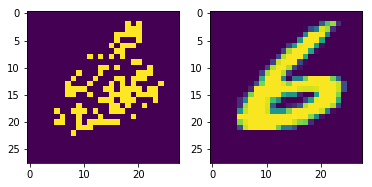

Train Iteration: 6500 [51456/60000 (86%)]	Loss: 145.159485
New Model Temperature: 0.6570468198150567


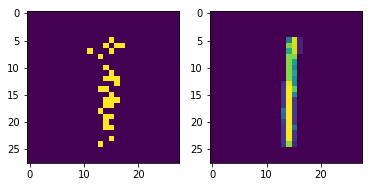

Train Iteration: 6600 [4224/60000 (7%)]	Loss: 138.717545
New Model Temperature: 0.6550786331118063


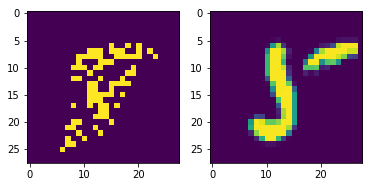

Train Iteration: 6700 [17024/60000 (28%)]	Loss: 142.876038
New Model Temperature: 0.6511599291810325


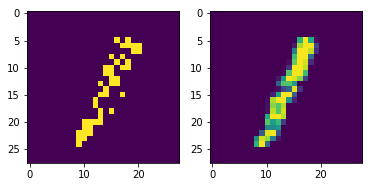

Train Iteration: 6800 [29824/60000 (50%)]	Loss: 139.523865
New Model Temperature: 0.6453257828572946


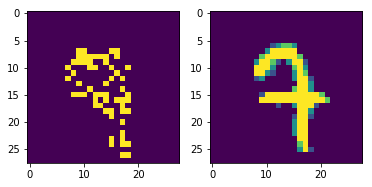

Train Iteration: 6900 [42624/60000 (71%)]	Loss: 142.520966
New Model Temperature: 0.6376281516217733


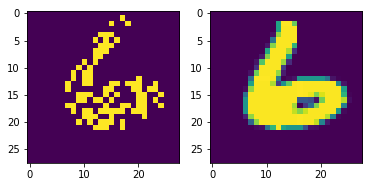

Train Iteration: 7000 [55424/60000 (92%)]	Loss: 142.814026
New Model Temperature: 0.6376281516217733


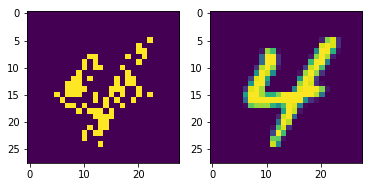

Train Iteration: 7100 [8192/60000 (14%)]	Loss: 139.095139
New Model Temperature: 0.6357181336264144


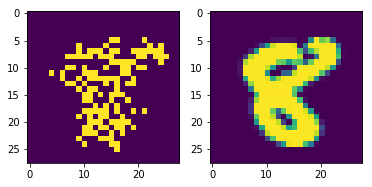

Train Iteration: 7200 [20992/60000 (35%)]	Loss: 145.355469
New Model Temperature: 0.631915244899496


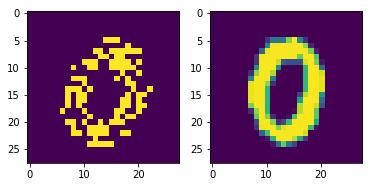

Train Iteration: 7300 [33792/60000 (56%)]	Loss: 147.061340
New Model Temperature: 0.626253523657556


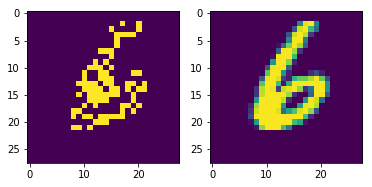

Train Iteration: 7400 [46592/60000 (78%)]	Loss: 141.911896
New Model Temperature: 0.618783391806141


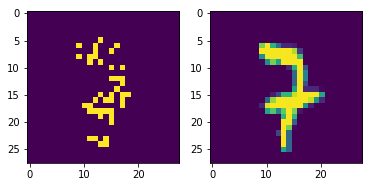

Train Iteration: 7500 [59392/60000 (99%)]	Loss: 137.207153
New Model Temperature: 0.618783391806141


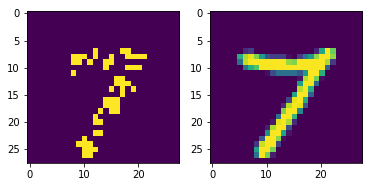

Train Iteration: 7600 [12160/60000 (20%)]	Loss: 140.803589
New Model Temperature: 0.6169298233735475


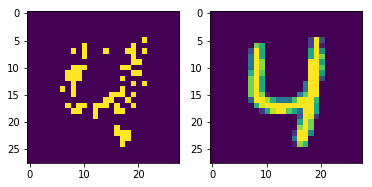

Train Iteration: 7700 [24960/60000 (42%)]	Loss: 136.106064
New Model Temperature: 0.6132393269939276


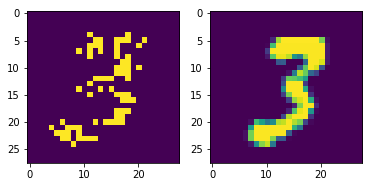

Train Iteration: 7800 [37760/60000 (63%)]	Loss: 141.176559
New Model Temperature: 0.6077449349024903


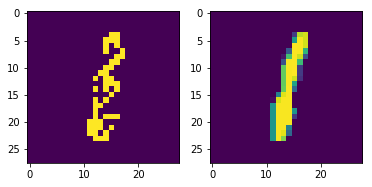

Train Iteration: 7900 [50560/60000 (84%)]	Loss: 141.987350
New Model Temperature: 0.600495578812266
New Model Temperature: 0.600495578812266


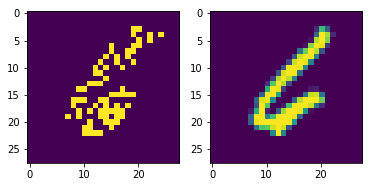

Train Iteration: 8000 [3328/60000 (6%)]	Loss: 136.093628
New Model Temperature: 0.5986967916057292


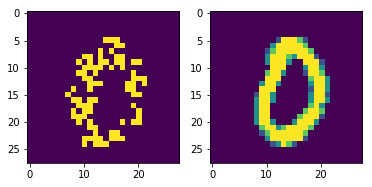

Train Iteration: 8100 [16128/60000 (27%)]	Loss: 142.974243
New Model Temperature: 0.5951153658775501


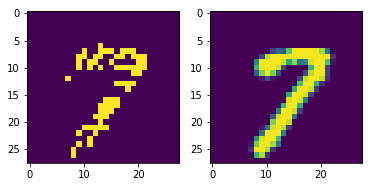

Train Iteration: 8200 [28928/60000 (48%)]	Loss: 141.733719
New Model Temperature: 0.5897833576128505


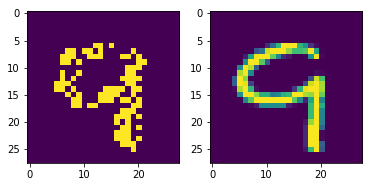

Train Iteration: 8300 [41728/60000 (70%)]	Loss: 138.764435
New Model Temperature: 0.5827482523739898


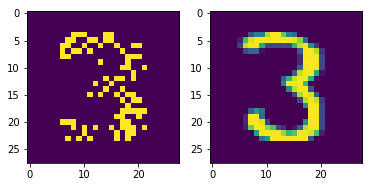

Train Iteration: 8400 [54528/60000 (91%)]	Loss: 139.522949
New Model Temperature: 0.5827482523739898


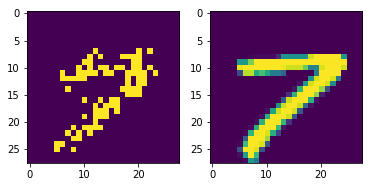

Train Iteration: 8500 [7296/60000 (12%)]	Loss: 132.537354
New Model Temperature: 0.581002627363602


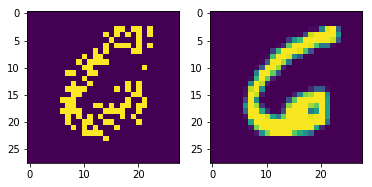

Train Iteration: 8600 [20096/60000 (33%)]	Loss: 137.473663
New Model Temperature: 0.5775270487619548


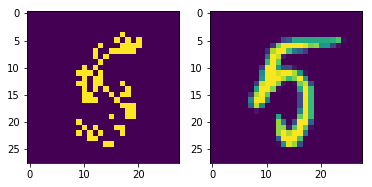

Train Iteration: 8700 [32896/60000 (55%)]	Loss: 137.457153
New Model Temperature: 0.5723526251566333


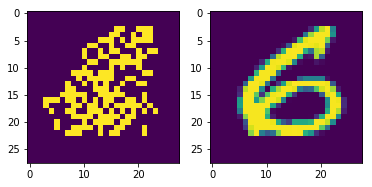

Train Iteration: 8800 [45696/60000 (76%)]	Loss: 146.170273
New Model Temperature: 0.5655254386995372


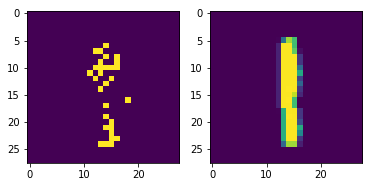

Train Iteration: 8900 [58496/60000 (97%)]	Loss: 142.952362
New Model Temperature: 0.5655254386995372


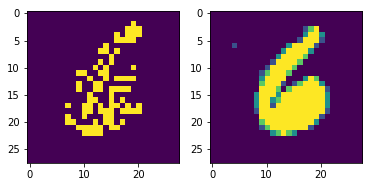

Train Iteration: 9000 [11264/60000 (19%)]	Loss: 141.329178
New Model Temperature: 0.5638314047049557


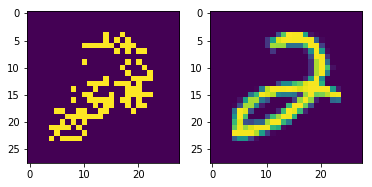

Train Iteration: 9100 [24064/60000 (40%)]	Loss: 139.243896
New Model Temperature: 0.5604585449744905


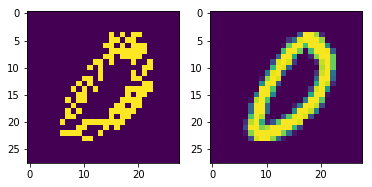

Train Iteration: 9200 [36864/60000 (61%)]	Loss: 140.282089
New Model Temperature: 0.5554370486980184


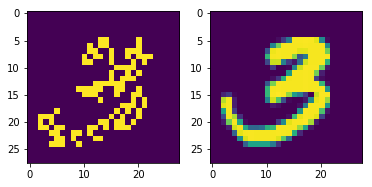

Train Iteration: 9300 [49664/60000 (83%)]	Loss: 139.160370
New Model Temperature: 0.5488116360940265
New Model Temperature: 0.5488116360940265


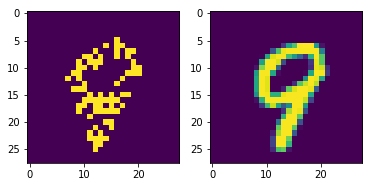

Train Iteration: 9400 [2432/60000 (4%)]	Loss: 130.388916
New Model Temperature: 0.5471676683703056


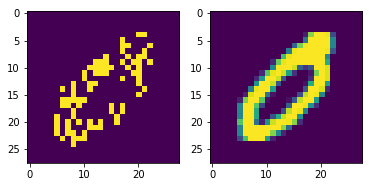

Train Iteration: 9500 [15232/60000 (25%)]	Loss: 135.948471
New Model Temperature: 0.54389449170959


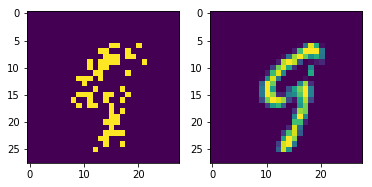

Train Iteration: 9600 [28032/60000 (47%)]	Loss: 135.260315
New Model Temperature: 0.5390214030763572


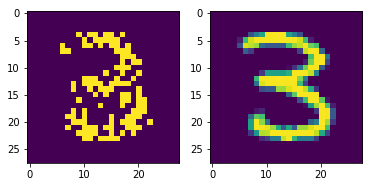

Train Iteration: 9700 [40832/60000 (68%)]	Loss: 137.762253
New Model Temperature: 0.5325918010068973


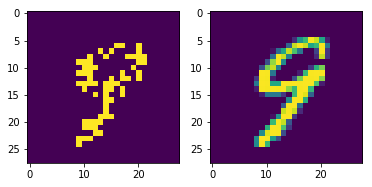

Train Iteration: 9800 [53632/60000 (89%)]	Loss: 142.307205
New Model Temperature: 0.5325918010068973


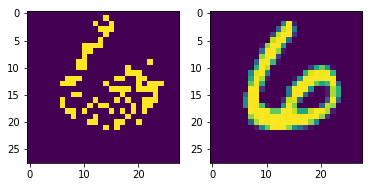

Train Iteration: 9900 [6400/60000 (11%)]	Loss: 140.283524
New Model Temperature: 0.5309964198721144


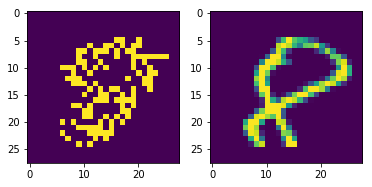

Train Iteration: 10000 [19200/60000 (32%)]	Loss: 137.325272
New Model Temperature: 0.5278199802012078


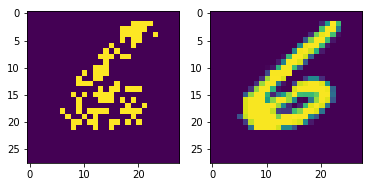

Train Iteration: 10100 [32000/60000 (53%)]	Loss: 137.008087
New Model Temperature: 0.5230909131025009


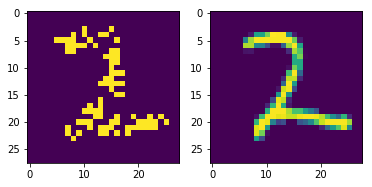

Train Iteration: 10200 [44800/60000 (75%)]	Loss: 134.525269
New Model Temperature: 0.5168513344916993


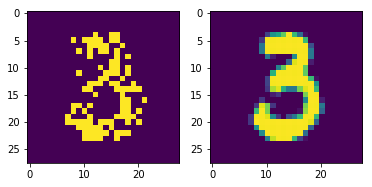

Train Iteration: 10300 [57600/60000 (96%)]	Loss: 139.928070


In [16]:
# model = VAE().to(device)
# optimizer = Adam(model.parameters(), lr=1e-3)
temp_min = 0.5
ANNEAL_RATE = 0.00003
train(model, optimizer, maxiters=10000)